# Генеративно-состязательные сети (Generative Adversarial Networks)

В задании предлагается реализовать GAN, обучить её на MNIST, оценить правдоподобие и сделать выводы.

Необходимая теория приведена ниже.

Актуальная версия доступна по адресу https://github.com/nadiinchi/dl_labs/blob/master/lab_gan.ipynb

## Постановка задачи
Дана выборка независимых одинаково распределенных величин из истинного распределения $x_i \sim p_d(x)$, $i = 1, \dots, N$.

Задача - построить вероятностную модель $p_\theta(x)$ истинного распределения $p_d(x)$.

Распределение $p_\theta(x)$ должно позволять как оценить плотность вероятности для данного объекта $x$, так и сэмплировать $x \sim p_\theta(x)$.

## Вероятностная модель
$z \in \mathbb{R}^d$ - локальная латентная переменная, т. е. своя для каждого объекта $x \in \mathbb{R}^D$.

Генеративный процесс вариационного автокодировщика:
1. Сэмплируем $z \sim p(z)$.
2. $x = G_\theta(z)$.

Параметры преобразования $G_\theta(z)$ задаются нейросетью с весами $\theta$, получающей на вход вектор $z$.

Индуцированная генеративным процессом плотность вероятности объекта $x$:

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z))$$

## Оценка логарифма правдоподобия
Для оценки логарифма правдоподобия используется метод Парзеновского окна/ядерного сглаживания (англ. Kernel Density Estimation/Parzen–Rosenblatt window method). Концептуально он заключается в том, что мы сглаживаем модельное распределение, и по этому сглаженному распределению вычисляем правдоподобие модели.

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z)) \approx \frac{1}{Mh^D}\sum_{i=1}^M K\left(\frac{x - G_\theta(z_i)}{h}\right)$$

Здесь $K(x)$ - любое распределение, а $h$ - ширина окна. Тогда выполняется

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{Mh^D}\sum_{j=1}^M K\left(\frac{x_i - G_\theta(z_j)}{h}\right)$$

В генеративно-состязательных сетях для оценки правдоподобия используется стандартное нормальное распределение $K(x) = N(x | 0, I)$. Тогда получаем

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{M}\sum_{j=1}^M \prod_{k=1}^D\frac{1}{\sqrt{2 \pi} \sigma}\exp\left(-\frac{(x_{i,k} - G(z_j)_k)^2}{2\sigma^2}\right)$$

Коэффициент $\sigma$ настраивается на валидационной выборке и с его помощью считается правдоподобие тестовой выборки.

### Загрузка, нормировка и визуалиация данных

In [1]:
import math
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import os, random

In [2]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Torch RNG
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Python RNG
    np.random.seed(seed)
    random.seed(seed)

In [3]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255)
data = MNIST('mnist', download=True, train=False)
test_data_raw = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255)

c:\program files\python38\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\program files\python38\lib\site-packages\torchvision\datasets\mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [4]:
digit_size = 14

In [5]:
train_data.tensors = (nn.AvgPool2d(2, 2)(train_data.tensors[0].view(-1, 28, 28)).data.view(-1, 196), )
test_data_raw.tensors = (nn.AvgPool2d(2, 2)(test_data_raw.tensors[0].view(-1, 28, 28)).data.view(-1, 196), )

In [6]:
valid_data = TensorDataset(test_data_raw.tensors[0][:5000])
test_data = TensorDataset(test_data_raw.tensors[0][5000:])

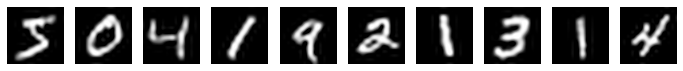

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, digit_size, digit_size)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(train_data[:10][0])

In [8]:
n = 15

from scipy.stats import norm
import numpy as np

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(generator):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])

            x_decoded = generator(z_sample)
            digit = x_decoded
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')
    plt.show()

### Функции и классы, описывающие модель и процесс её обучения

In [9]:
class Reshape(nn.Module):
    def __init__(self, *args):
        """
        Запоминает размерности, в которые при проходе
        вперед будут переводиться все объекты.
        Например,
            input = torch.zeros(100, 196)
            reshape_layer = Reshape(1, 14, 14)
            reshape_layer(input)
        возвращает тензор размерности (100, 1, 14, 14).
            input = torch.zeros(100, 1, 14, 14)
            reshape_layer = Reshape(-1)
            reshape_layer(input)
        наоборот вернет тензор размерности (100, 196).
        """
        super(type(self), self).__init__()
        self.dims = args

    def forward(self, input):
        """
        Возвращает тензор с измененными размерностями объектов.
        Вход: input, FloatTensor.
        Возвращаемое значение: FloatTensor.
        """
        return input.view(input.size(0), *self.dims)

In [10]:
class GAN(nn.Module):
    def __init__(self, d, discriminator_loss_noisiness=None, generator_modified_loss_probability=1):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        seed_everything(666)
        super(type(self), self).__init__()
        self.d = d
        self.discriminator_loss_noisiness = discriminator_loss_noisiness
        self.generator_modified_loss_probability = generator_modified_loss_probability
        # Можно пробовать другие архитектуры: как более сложные
        # сверточные, так и более простые, например, полносвязные.
        # Однако желательно обучить хотя бы одну сверточную модель.
        self.discriminator = nn.Sequential(
            Reshape(1, 14, 14),
            nn.Conv2d(1, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, 3, 2, 0, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, 3, 1, 0, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            Reshape(-1),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        self.generator = nn.Sequential(
            Reshape(self.d, 1, 1),
            nn.ConvTranspose2d(self.d, 128, 4, 1, 0, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 1, 3, 2, 1, 1, bias=False),
            Reshape(-1),
            nn.Sigmoid()
        )

    def generate_noise(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x d.
        """
        # ваш код здесь
        z = torch.randn(num_samples, self.d)
        if next(self.parameters()).is_cuda:
            z = z.cuda()
        return z

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x D.
        """
        z = self.generate_noise(num_samples)
        x = self.generator(z)
        return x

    def discriminator_loss(self, batch):
        """
        Вычисляет значение функции потерь дискриминатора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектов размера n x D.
        Возвращаемое значение: Tensor, скаляр - значение функции потерь
        дискриминатора на данном батче.
        """
        fake_batch = self.generate_samples(len(batch))
        if self.discriminator_loss_noisiness is None:
            expected_real_loss = -torch.log(self.discriminator(batch)).mean()
            expected_fake_loss = -torch.log(1-self.discriminator(fake_batch)).mean()
        else:
            to_flip = int(len(batch) * self.discriminator_loss_noisiness)
            expected_real_loss = (-torch.log(self.discriminator(batch[to_flip:])).mean() - torch.log(self.discriminator(fake_batch[:to_flip])).mean())/2
            expected_fake_loss = (-torch.log(1-self.discriminator(fake_batch[to_flip:])).mean() - torch.log(1-self.discriminator(batch[:to_flip])).mean())/2
        
        loss = expected_real_loss + expected_fake_loss
        return loss

    def generator_loss(self, batch):
        """
        Вычисляет значение функции потерь генератора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Tensor, скаляр - значение функции потерь
        генератора на данном батче.
        """
        fake_batch = self.generate_samples(len(batch))
        if np.random.random() < self.generator_modified_loss_probability:
            loss = -torch.log(self.discriminator(fake_batch)).mean() # better training on earlier stages
        else:
            loss = torch.log(1-self.discriminator(fake_batch)).mean()
        return loss

In [11]:
def log_mean_exp(mtx):
    """
    Возвращает логарифм среднего по каждому столбцу от экспоненты данной матрицы.
    Подсказка: не забывайте про вычислительную стабильность!
    Вход: mtx, Tensor - матрица размера n x k.
    Возвращаемое значение: Tensor, вектор длины n.
    """
    mtx_max = mtx.max(dim=1, keepdims=True).values
    m = torch.exp(mtx - mtx_max).mean(dim=1)
    lme = torch.log(m) + mtx_max
    return lme

In [12]:
def log_likelihood_reduced(x, y, log_sigma):
    """
    Возвращает оценку логарифма правдоподобия y по распределению, оцениваемому с помощью x, и данным log(sigma) 
    """
    with torch.no_grad():
        quad_term = -(torch.sum(x ** 2, dim=1)[:, None] - 2 * torch.mm(x, y.T) + torch.sum(y ** 2, dim=1)[None, :]) / 2 / np.exp(2 * log_sigma)
        log_term = -x.size(1) * (np.log(2 * np.pi) / 2 + log_sigma)
        dist = quad_term + log_term
        log_lik = float(log_mean_exp(dist).mean())
    return log_lik

def log_likelihood(generated_set, validation_set, test_set):
    """
    Возвращает оценку логарифма правдоподобия модели GAN методом
    Парзеновского окна со стандартным нормальным ядром.
    Подсказка: sigma должна настраиваться по валидационной выборке, а
    правдоподобие считаться по тестовой.
    Подсказка: вместо sigma можно настраивать log_sigma.
    Подсказка: для настойки sigma допустимо использовать как перебор по сетке,
    так и другие методы оптимизации.
    Вход: generated_set - сэмплы из генеративной модели.
    Вход: validation_set - валидационная выборка.
    Вход: test_set - тестовая выборка.
    Возвращаемое значение: float (не Tensor!) - оценка логарифма правдоподобия.
    """
    
    grid = np.linspace(np.log(0.25), 0, num=40)
    grid_val = [log_likelihood_reduced(validation_set, generated_set, log_sigma) for log_sigma in grid]
    log_sigma = grid[np.argmax(grid_val)]
    
    log_lik = log_likelihood_reduced(test_set, generated_set, log_sigma)
    
    return log_lik

In [13]:
def generate_many_samples(model, num_samples, batch_size):
    size = 0
    res = []
    while size < num_samples:
        res.append(model.generate_samples(min(batch_size, num_samples - size)))
        size += batch_size
    return torch.cat(res, 0)

In [14]:
def train_model(model, name, num_epochs=100, batch_size=64, learning_rate=2e-4, beta1=0.5, beta2=0.999, clamp_value=0.2):
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: k, int - число итераций оптимизации дискриминатора на итерацию оптимизации
    генератора.
    Вход: batch_size, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'generator_losses' - список значений функции потерь генератора,
    'discriminator_losses' - список значений функции потерь дискриминатора.
    """
    seed_everything(666)
    if torch.cuda.is_available():
        model = model.cuda()
    model.train()

    # возможно, нужно подобрать другие параметры, чтобы модель обучилась
    #batch_size = 64
    #learning_rate = 2e-4

    # возможно, нужно использовать другие методы оптимизации или параметры методов оптимизации,
    # чтобы модель обучилась
    gd_generator = optim.Adam(model.generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    gd_discriminator = optim.RMSprop(model.discriminator.parameters(), lr=learning_rate)

    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    total_batches = len(dataloader)

    generator_losses = [0]
    discriminator_losses = [0]
    log_likelihoods = []

    generated_samples = generate_many_samples(model, 512, batch_size).detach()
    valid_samples = valid_data[np.random.choice(len(valid_data), 512, False)][0]
    valid_samples = valid_samples.to(next(model.parameters()).device)
    test_samples = test_data[np.random.choice(len(test_data), 512, False)][0]
    test_samples = test_samples.to(next(model.parameters()).device)    
    
    ll = log_likelihood(generated_samples, valid_samples, test_samples)
    log_likelihoods.append(ll)
    print('Log-likelihood', ll, flush=True)
    best_ll = ll
    torch.save(model.state_dict(), 'best_{}'.format(name))
    
    for epoch in range(num_epochs):
        for i, (batch, ) in enumerate(dataloader):
            if torch.cuda.is_available():
                batch = batch.cuda()

            # ваш код здесь!
            # разрешается менять код этой функции для реализации
            # более сложных процедур обучения или ускорения обучения

            gd_discriminator.zero_grad()
            discriminator_loss = model.discriminator_loss(batch)
            discriminator_loss.backward()
            for param in model.discriminator.parameters():
                param.grad.data.clamp_(-clamp_value, clamp_value)
            gd_discriminator.step()

            gd_generator.zero_grad()
            generator_loss = model.generator_loss(batch)
            generator_loss.backward()
            for param in model.generator.parameters():
                param.grad.data.clamp_(-clamp_value, clamp_value)
            gd_generator.step()

            # не забудьте корректно сохранить статистику
            discriminator_losses.append(float(discriminator_loss))
            generator_losses.append(float(generator_loss))

            if (i + 1) % 100 == 0:
                print('\rEpoch:', epoch, 'G_loss:', generator_losses[-1],
                      'D_loss:', discriminator_losses[-1],
                      'Batch', i + 1, 'of', total_batches,
                      ' ' * 10, end='', flush=True)
        print(flush=True)
        generated_samples = generate_many_samples(model, 512, batch_size).detach()
        valid_samples = valid_data[np.random.choice(len(valid_data), 512, False)][0]
        valid_samples = valid_samples.to(next(model.parameters()).device)
        test_samples = test_data[np.random.choice(len(test_data), 512, False)][0]
        test_samples = test_samples.to(next(model.parameters()).device)
        ll = log_likelihood(generated_samples, valid_samples, test_samples)
        log_likelihoods.append(ll)
        print('Log-likelihood', ll, flush=True)
        
        if ll > best_ll:
            torch.save(model.state_dict(), 'best_{}'.format(name))

    model.load_state_dict(torch.load('best_{}'.format(name)))
    return {
        'model': model.cpu(),
        'generator_losses': generator_losses,
        'discriminator_losses': discriminator_losses,
        'log_likelihoods': log_likelihoods
    }

### Обучение модели

In [37]:
seed_everything(666)

In [38]:
# Подсказка: обучать GANs со скрытой размерностью 2 непросто,
# для этого требуется очень аккуратно подобрать хаки/процесс обучения/
# /архитектуру модели/инициализацию.
# Если не получается сразу, стоит обучить GANs с бОльшей скрытой размерностью,
# а затем вернуться к этой ячейке.
g2 = GAN(2, discriminator_loss_noisiness=0.1)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d2 = train_model(g2, 'g2', num_epochs=50, clamp_value=0.2, beta1=0.5, learning_rate=1e-4)

Log-likelihood -123.54572296142578
Epoch: 0 G_loss: 0.6215519309043884 D_loss: 1.4108166694641113 Batch 900 of 938           
Log-likelihood -137.49371337890625
Epoch: 1 G_loss: 0.6715346574783325 D_loss: 1.3991470336914062 Batch 900 of 938           
Log-likelihood -129.03903198242188
Epoch: 2 G_loss: 0.6909794807434082 D_loss: 1.3869868516921997 Batch 900 of 938           
Log-likelihood -99.46197509765625
Epoch: 3 G_loss: 0.6925877928733826 D_loss: 1.3864004611968994 Batch 900 of 938           
Log-likelihood -96.54971313476562
Epoch: 4 G_loss: 0.6917182207107544 D_loss: 1.3856303691864014 Batch 900 of 938           
Log-likelihood -129.94393920898438
Epoch: 5 G_loss: 0.6915479898452759 D_loss: 1.3858082294464111 Batch 900 of 938           
Log-likelihood -129.38723754882812
Epoch: 6 G_loss: 0.6899125576019287 D_loss: 1.3845598697662354 Batch 900 of 938           
Log-likelihood -98.14706420898438
Epoch: 7 G_loss: 0.6920571327209473 D_loss: 1.386568307876587 Batch 900 of 938        

In [17]:
g10 = GAN(10)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d10 = train_model(g10, 'g10', num_epochs=30)

Log-likelihood -127.12528991699219
Epoch: 0 G_loss: 0.7292406558990479 D_loss: 1.3126914501190186 Batch 900 of 938           
Log-likelihood -20.084148406982422
Epoch: 1 G_loss: 0.716671347618103 D_loss: 1.3407026529312134 Batch 900 of 938            
Log-likelihood 20.276336669921875
Epoch: 2 G_loss: 0.8030107021331787 D_loss: 1.3857526779174805 Batch 900 of 938           
Log-likelihood 24.06390953063965
Epoch: 3 G_loss: 0.7516230344772339 D_loss: 1.3175880908966064 Batch 900 of 938           
Log-likelihood 29.012348175048828
Epoch: 4 G_loss: 0.7448691129684448 D_loss: 1.3337693214416504 Batch 900 of 938           
Log-likelihood 29.900785446166992
Epoch: 5 G_loss: 0.7420054078102112 D_loss: 1.3944625854492188 Batch 900 of 938           
Log-likelihood 32.010658264160156
Epoch: 6 G_loss: 0.7879253029823303 D_loss: 1.3014373779296875 Batch 900 of 938           
Log-likelihood 33.05424499511719
Epoch: 7 G_loss: 0.7469554543495178 D_loss: 1.3075196743011475 Batch 900 of 938           


In [18]:
g100 = GAN(100)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d100 = train_model(g100, 'g100', num_epochs=30)

Log-likelihood -140.98106384277344
Epoch: 0 G_loss: 0.8084364533424377 D_loss: 1.1918779611587524 Batch 900 of 938           
Log-likelihood -61.93727111816406
Epoch: 1 G_loss: 0.821017324924469 D_loss: 1.2244243621826172 Batch 900 of 938            
Log-likelihood 16.480737686157227
Epoch: 2 G_loss: 0.8620234131813049 D_loss: 1.195478916168213 Batch 900 of 938            
Log-likelihood 19.835081100463867
Epoch: 3 G_loss: 0.8609027862548828 D_loss: 1.2179503440856934 Batch 900 of 938           
Log-likelihood 24.00077247619629
Epoch: 4 G_loss: 0.9359121322631836 D_loss: 1.1444592475891113 Batch 900 of 938           
Log-likelihood 25.50997543334961
Epoch: 5 G_loss: 0.8713257312774658 D_loss: 1.048731803894043 Batch 900 of 938            
Log-likelihood 29.709627151489258
Epoch: 6 G_loss: 1.0582793951034546 D_loss: 1.0608049631118774 Batch 900 of 938           
Log-likelihood 30.724288940429688
Epoch: 7 G_loss: 1.1031298637390137 D_loss: 1.1038000583648682 Batch 900 of 938           
L

### Анализ результатов

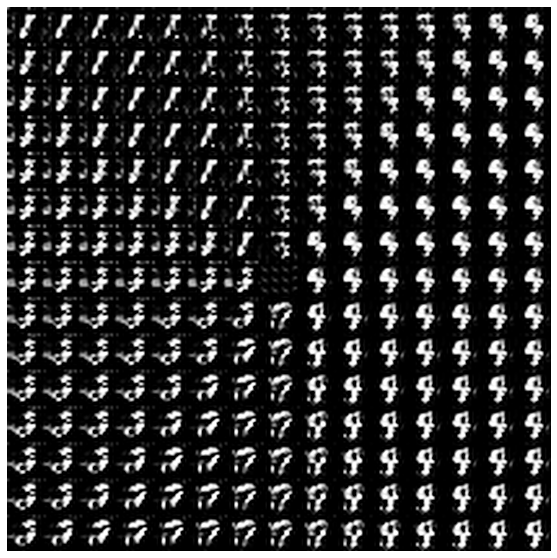

In [39]:
def draw_manifold_gan(model):
    generator = lambda z: model.generator(torch.from_numpy(z).float()).view(digit_size, digit_size).data.numpy()
    return draw_manifold(generator)

draw_manifold_gan(gan_model_d2['model'])

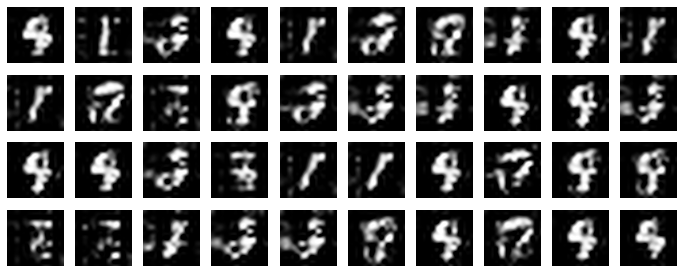

In [40]:
show_images(gan_model_d2['model'].generate_samples(40))

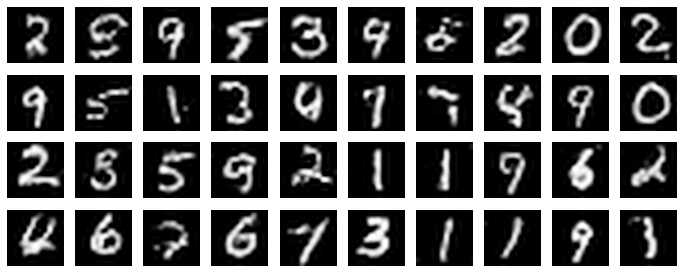

In [21]:
show_images(gan_model_d10['model'].generate_samples(40))

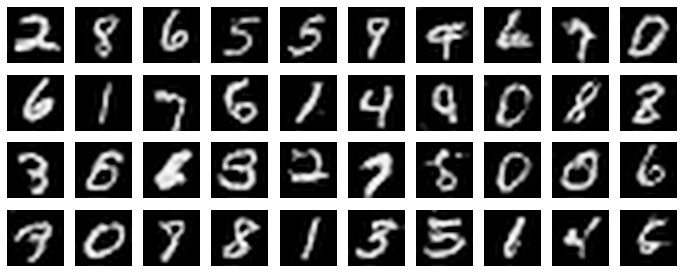

In [22]:
show_images(gan_model_d100['model'].generate_samples(40))

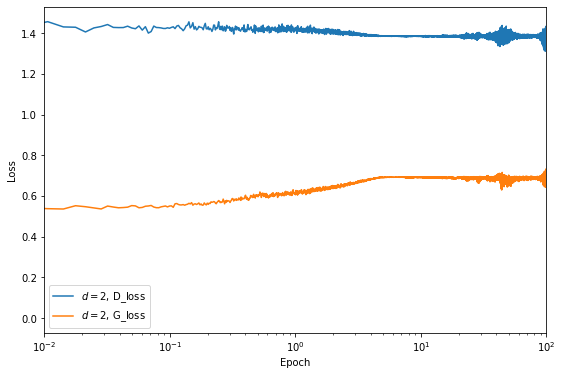

In [23]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, D_loss', 'discriminator_losses', gan_model_d2),
    ('$d = 2$, G_loss', 'generator_losses', gan_model_d2),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

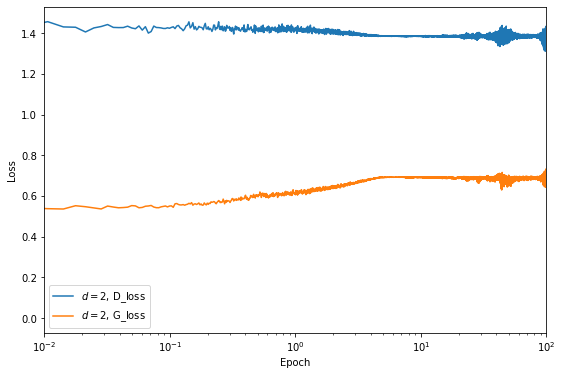

In [24]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, D_loss', 'discriminator_losses', gan_model_d2),
    ('$d = 2$, G_loss', 'generator_losses', gan_model_d2),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

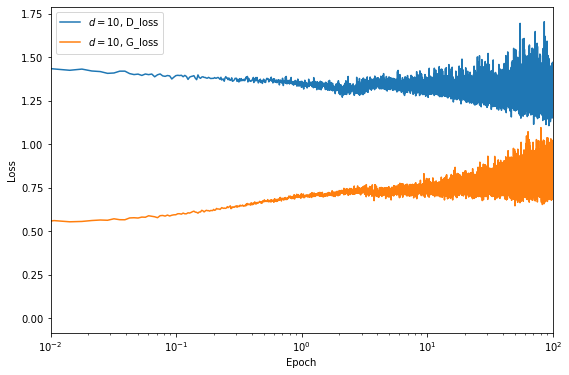

In [25]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 10$, D_loss', 'discriminator_losses', gan_model_d10),
    ('$d = 10$, G_loss', 'generator_losses', gan_model_d10),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

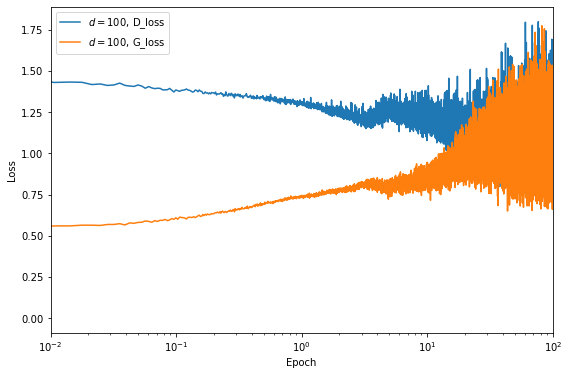

In [26]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 100$, D_loss', 'discriminator_losses', gan_model_d100),
    ('$d = 100$, G_loss', 'generator_losses', gan_model_d100),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

In [27]:
generated_samples = generate_many_samples(gan_model_d2['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

Wall time: 20.6 s


-46.1628303527832

In [28]:
generated_samples = generate_many_samples(gan_model_d10['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

Wall time: 23.2 s


50.42510986328125

In [29]:
generated_samples = generate_many_samples(gan_model_d100['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

Wall time: 23.1 s


49.65143585205078

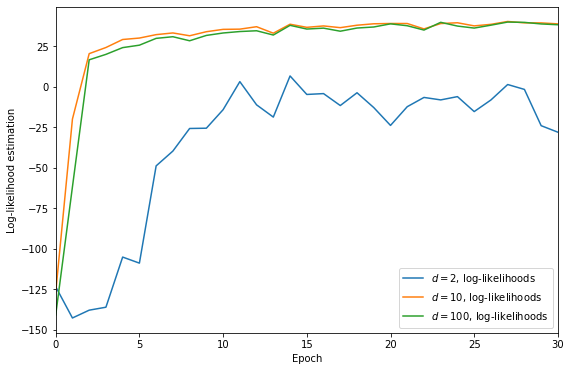

In [36]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, log-likelihoods', 'log_likelihoods', gan_model_d2),
    ('$d = 10$, log-likelihoods', 'log_likelihoods', gan_model_d10),
    ('$d = 100$, log-likelihoods', 'log_likelihoods', gan_model_d100),
]:
    data = model[name]
    x_labels = np.arange(len(data))
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.0, xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation')
plt.legend()
pass

## Выводы
Место для ваших выводов, наблюдений, гипотез.

В процессе реализации методов обучения я прибегнул к ряду трюков. Прежде всего, чтобы хоть что-то заработало, было необходимо ограничить градиент по модулю --- иначе уже на ранних стадиях градиент оказывался бесконечным и это приводило к невозможности обучить модель. Также я с самого начала использовал модифицированную функцию потерь генератора, которая имеет меньше проблем с пропуском градиента на ранних стадиях обучения. Позже я проверил, не работает ли стандартная лучше, оказалось, что нет.

Для моделей с 10- и 100-мерными латентными пространствами этого было достаточно, они легко обучились и произвели правдоподобные цифры даже с предоставленными заранее параметрами обучения. Проблемы у меня были с двумерным латентным пространством, и задача эта была весьма сложной. Низкомерное латентное пространство даёт очень мало свободы генератору, и я многократно встречал mode collapse. Чтобы избежать этого, я использовал случайную перестановку меток --- дискриминатора штрафовало за правильную классификацию некоторой доли объектов. Но даже если я избегал mode collapse, модель часто посреди обучения расходилась и забывала всё выученное. На последнем графике видно один из таких случаев. В предложенной архитектуре дискриминатор использует leaky ReLU, а в генераторе только обычные ReLU. Я попробовал заменить их на leaky ReLU, это не помогло с обучением. Попробовал я также делать несколько шагов оптимизации генератора на один шаг дискриминатора, не помогло. В конечном итоге заработало использование других параметров оптимизатора --- я уменьшил влияние инерции градиента.

Эти эксперименты я здесь не привожу, чтобы не загромождать ноутбук и не увеличивать время проверки.

В целом, хотя обучить модели с многомерным латентным пространством оказалось просто, я прочувствовал сложность обучения GAN на двумерной задаче. Я столкнулся со всем, что мы обсуждали на лекциях, и это пришлось решать тонкой настройкой.

Дополнение: когда я проверял, воспроизводятся ли результаты ноутбука, я обнаружил, что веса изначально инициализируются так же, но почему-то процесс обучения имеет какую-то недетерминированность, которую мои функции фиксирования не охватывают. Сетка с двумерным латентным пространством стала вновь расходиться. Для исправления этой проблемы я реализовал запоминание весов при лучшем логарифме правдоподобия.